In [194]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as pd
import numpy as np
import os
import pickle
from tqdm import tqdm
from data.util.paths import DATA_PATH
from mpl_toolkits.axes_grid1 import make_axes_locatable
tqdm.pandas()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
from lib.processing import save_to_pkl, load_from_pkl
from data.scripts.project_data import DataLoader
from data.util.environment_variables import COUNTRY_CODES, M49_TO_ISO3

In [82]:
concat_df = load_from_pkl('concat')

In [246]:
concat_columns = set(concat_df.columns)

In [247]:
get_col_set = lambda x: set([column for column in concat_columns if x in column])

format_description_columns = get_col_set('format_description_')
format_name_columns = get_col_set('format_name_')
format_columns = set([*format_description_columns,*format_name_columns,'format_text_clean','format_quantity'])


In [248]:
superregion_columns = get_col_set('superregion_')
region_columns = get_col_set('region_')
country_columns = get_col_set('country_')
geography_columns = set([*superregion_columns,*region_columns,*country_columns])


In [249]:
period_columns = get_col_set('_period')
era_columns = get_col_set('_era')

In [250]:
genre_columns = get_col_set('genre_')
style_columns = get_col_set('style_')

In [251]:
rest_columns = concat_columns-format_columns-geography_columns-genre_columns-style_columns-period_columns-era_columns

In [252]:
rest_columns

{'artist',
 'artist_clean',
 'average_rating',
 'community_have',
 'community_want',
 'country',
 'format_description',
 'format_text',
 'formats',
 'genre',
 'have',
 'highest',
 'label',
 'label_clean',
 'last_sold',
 'lowest',
 'market_price',
 'market_value',
 'master_id',
 'median',
 'no_of_days_since_last_sale',
 'number_of_tracks',
 'rating_count',
 'release_id',
 'release_url',
 'running_time',
 'standards_count',
 'style',
 'thumb_url',
 'title',
 'track_titles',
 'units_for_sale',
 'want',
 'year'}

## Visualizations
- Pairplot of all Numerics
- Evolution of market_value over time
- Most frequent genres
- Most frequent styles
- Most frequent formats
- Geographical mapping
- how many releases per year

In [389]:
concat_df[rest_columns].dtypes

artist_clean                          object
running_time                         float64
genre                                 object
formats                               object
have                                 float64
thumb_url                             object
master_id                              int64
market_value                         float64
format_description                    object
country                               object
release_id                             int64
standards_count                        int64
style                                 object
label_clean                           object
lowest                               float64
last_sold                     datetime64[ns]
title                                 object
want                                 float64
community_want                         int64
release_url                           object
number_of_tracks                     float64
artist                                object
community_

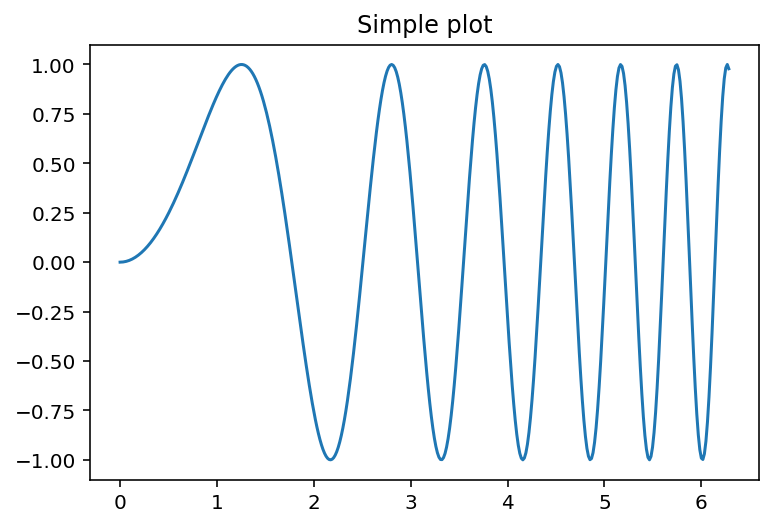

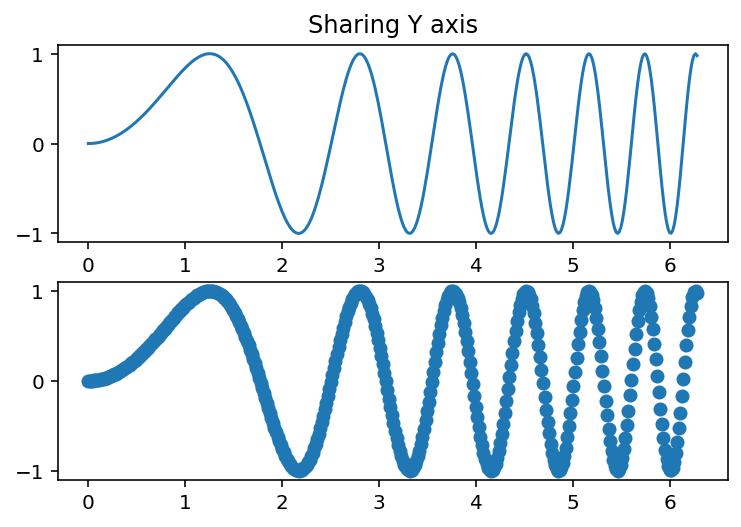

In [403]:
# First create some toy data:
x = np.linspace(0, 2*np.pi, 400)
y = np.sin(x**2)

# Create just a figure and only one subplot
fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_title('Simple plot')

# Create two subplots and unpack the output array immediately
f, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(x, y)
ax1.set_title('Sharing Y axis')
ax2.scatter(x, y)

AttributeError: 'PathCollection' object has no property 'fillstyle'

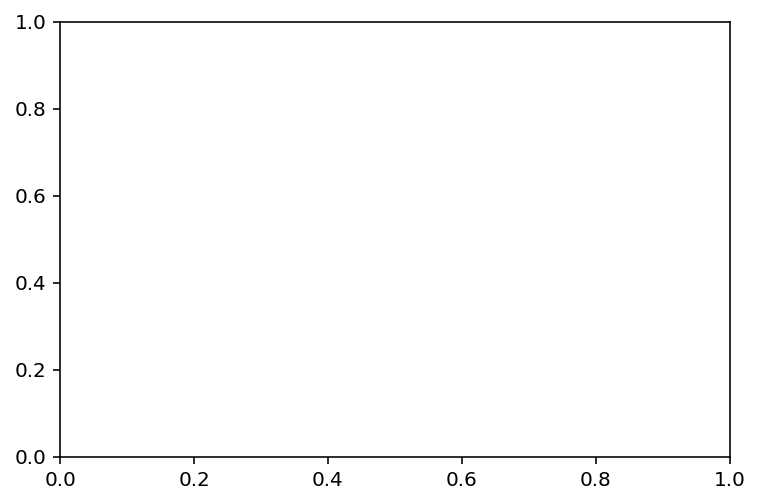

In [424]:
plt.scatter(concat_df['market_value'],concat_df['running_time'],marker='o')

<Figure size 7200x1440 with 0 Axes>

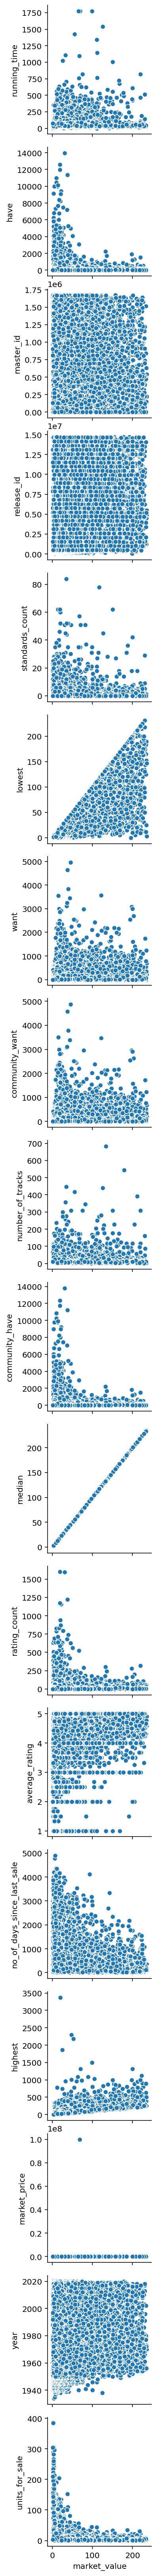

In [416]:
grid = sns.pairplot(concat_df[rest_columns],x_vars=['market_value'],y_vars=pairplot_columns)
plt.show();

## Genres

In [297]:
def get_encoded_df_and_count(columns):
    column_df = concat_df[columns].rename(columns={column:column.split('_')[-1] for column in columns})
    column_sum = column_df.sum().sort_values(ascending=False)
    return column_df, column_sum

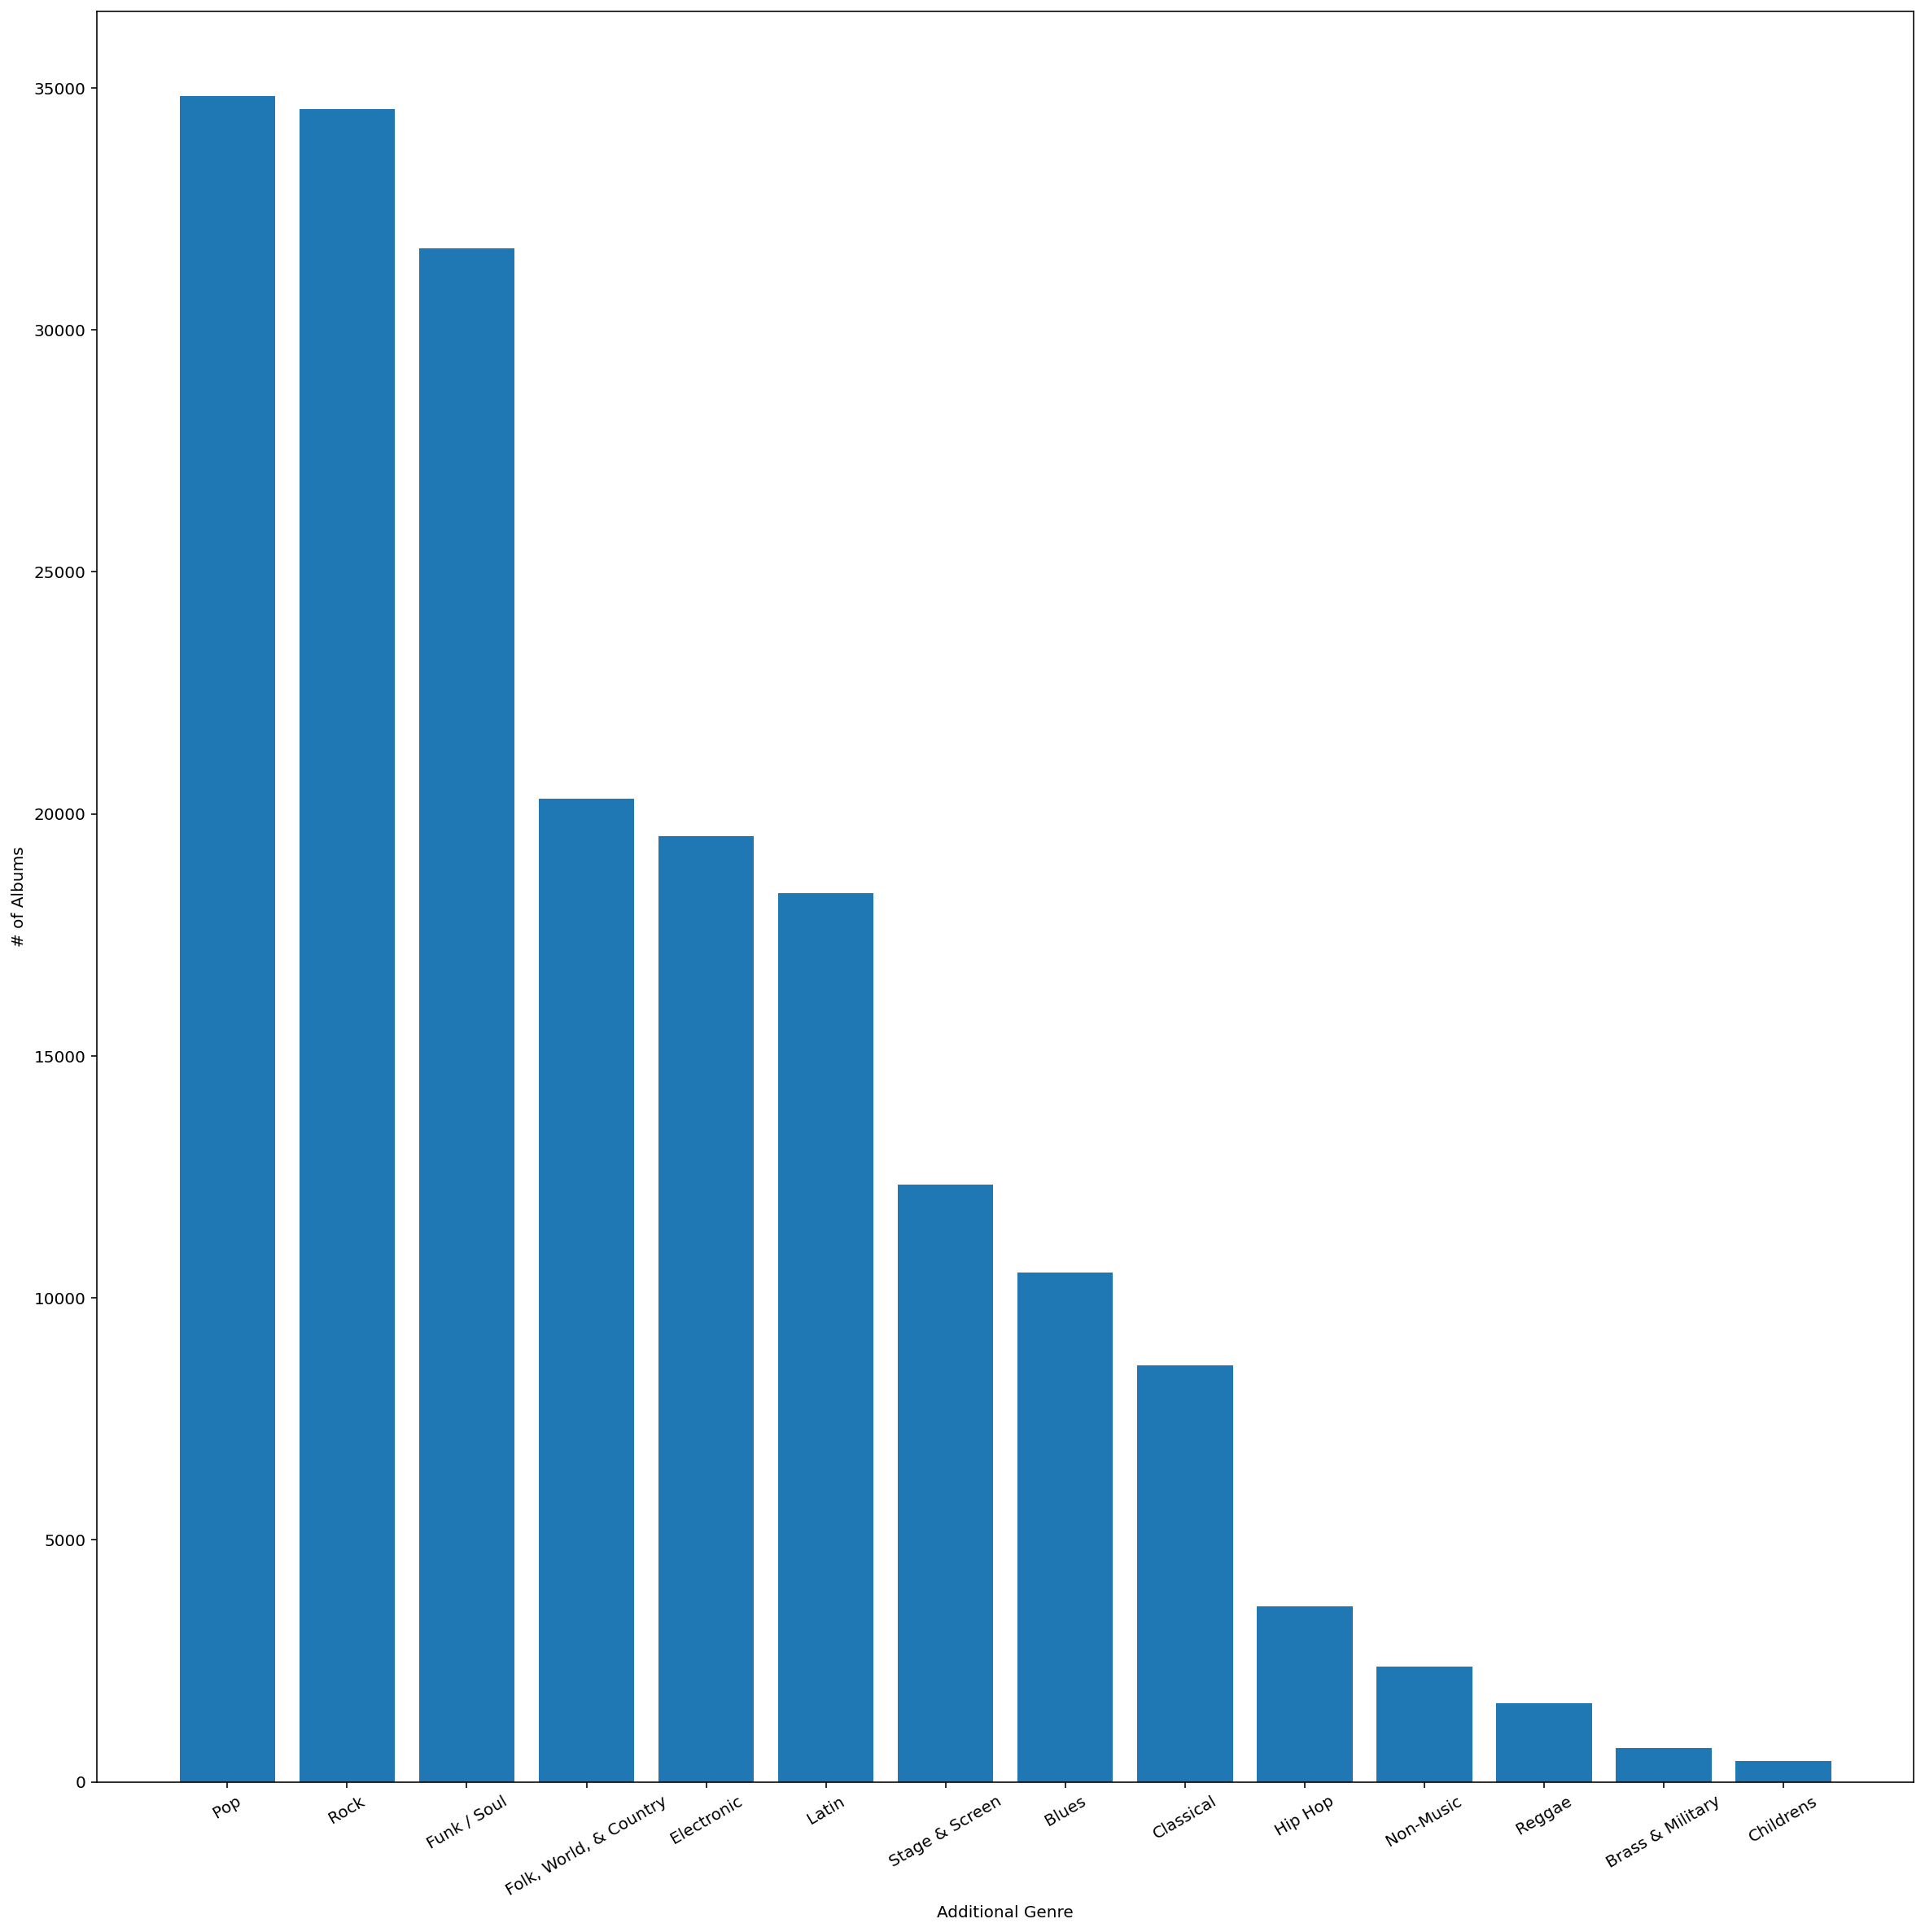

In [298]:
genre_df, genre_sum = get_encoded_df_and_count(genre_columns)

plt.figure(figsize=(20,20))
plt.xlabel('Additional Genre')
plt.ylabel('# of Albums')
plt.xticks(rotation=30)
plt.bar(genre_sum.index,genre_sum)
plt.show()

In [271]:
#How many 'pure' jazz albums
pure_jazz_albums = len(genre_df[genre_df.sum(axis=1)==0])
print('There are {} albums which only list Jazz as a genre, {}% of the dataset'.format(pure_jazz_albums,round(100*pure_jazz_albums/len(concat_df),2)))

There are 166494 albums which only list Jazz as a genre, 55.96% of the dataset


## Styles

In [292]:
style_df, style_sum = get_encoded_df_and_count(style_columns)
style_sum

Contemporary Jazz    36092
Easy Listening       28230
Fusion               24688
Jazz-Funk            18262
Jazz-Rock            16108
                     ...  
Deathrock                1
Champeta                 1
Kwaito                   1
Klasik                   1
Cretan                   1
Length: 500, dtype: int64

In [293]:
style_sum.describe()

count      500.000000
mean       937.010000
std       3384.101954
min          1.000000
25%          7.750000
50%         38.000000
75%        262.750000
max      36092.000000
dtype: float64

In [294]:
style_sum_top_10 = style_sum[style_sum > style_sum.quantile(0.9)]

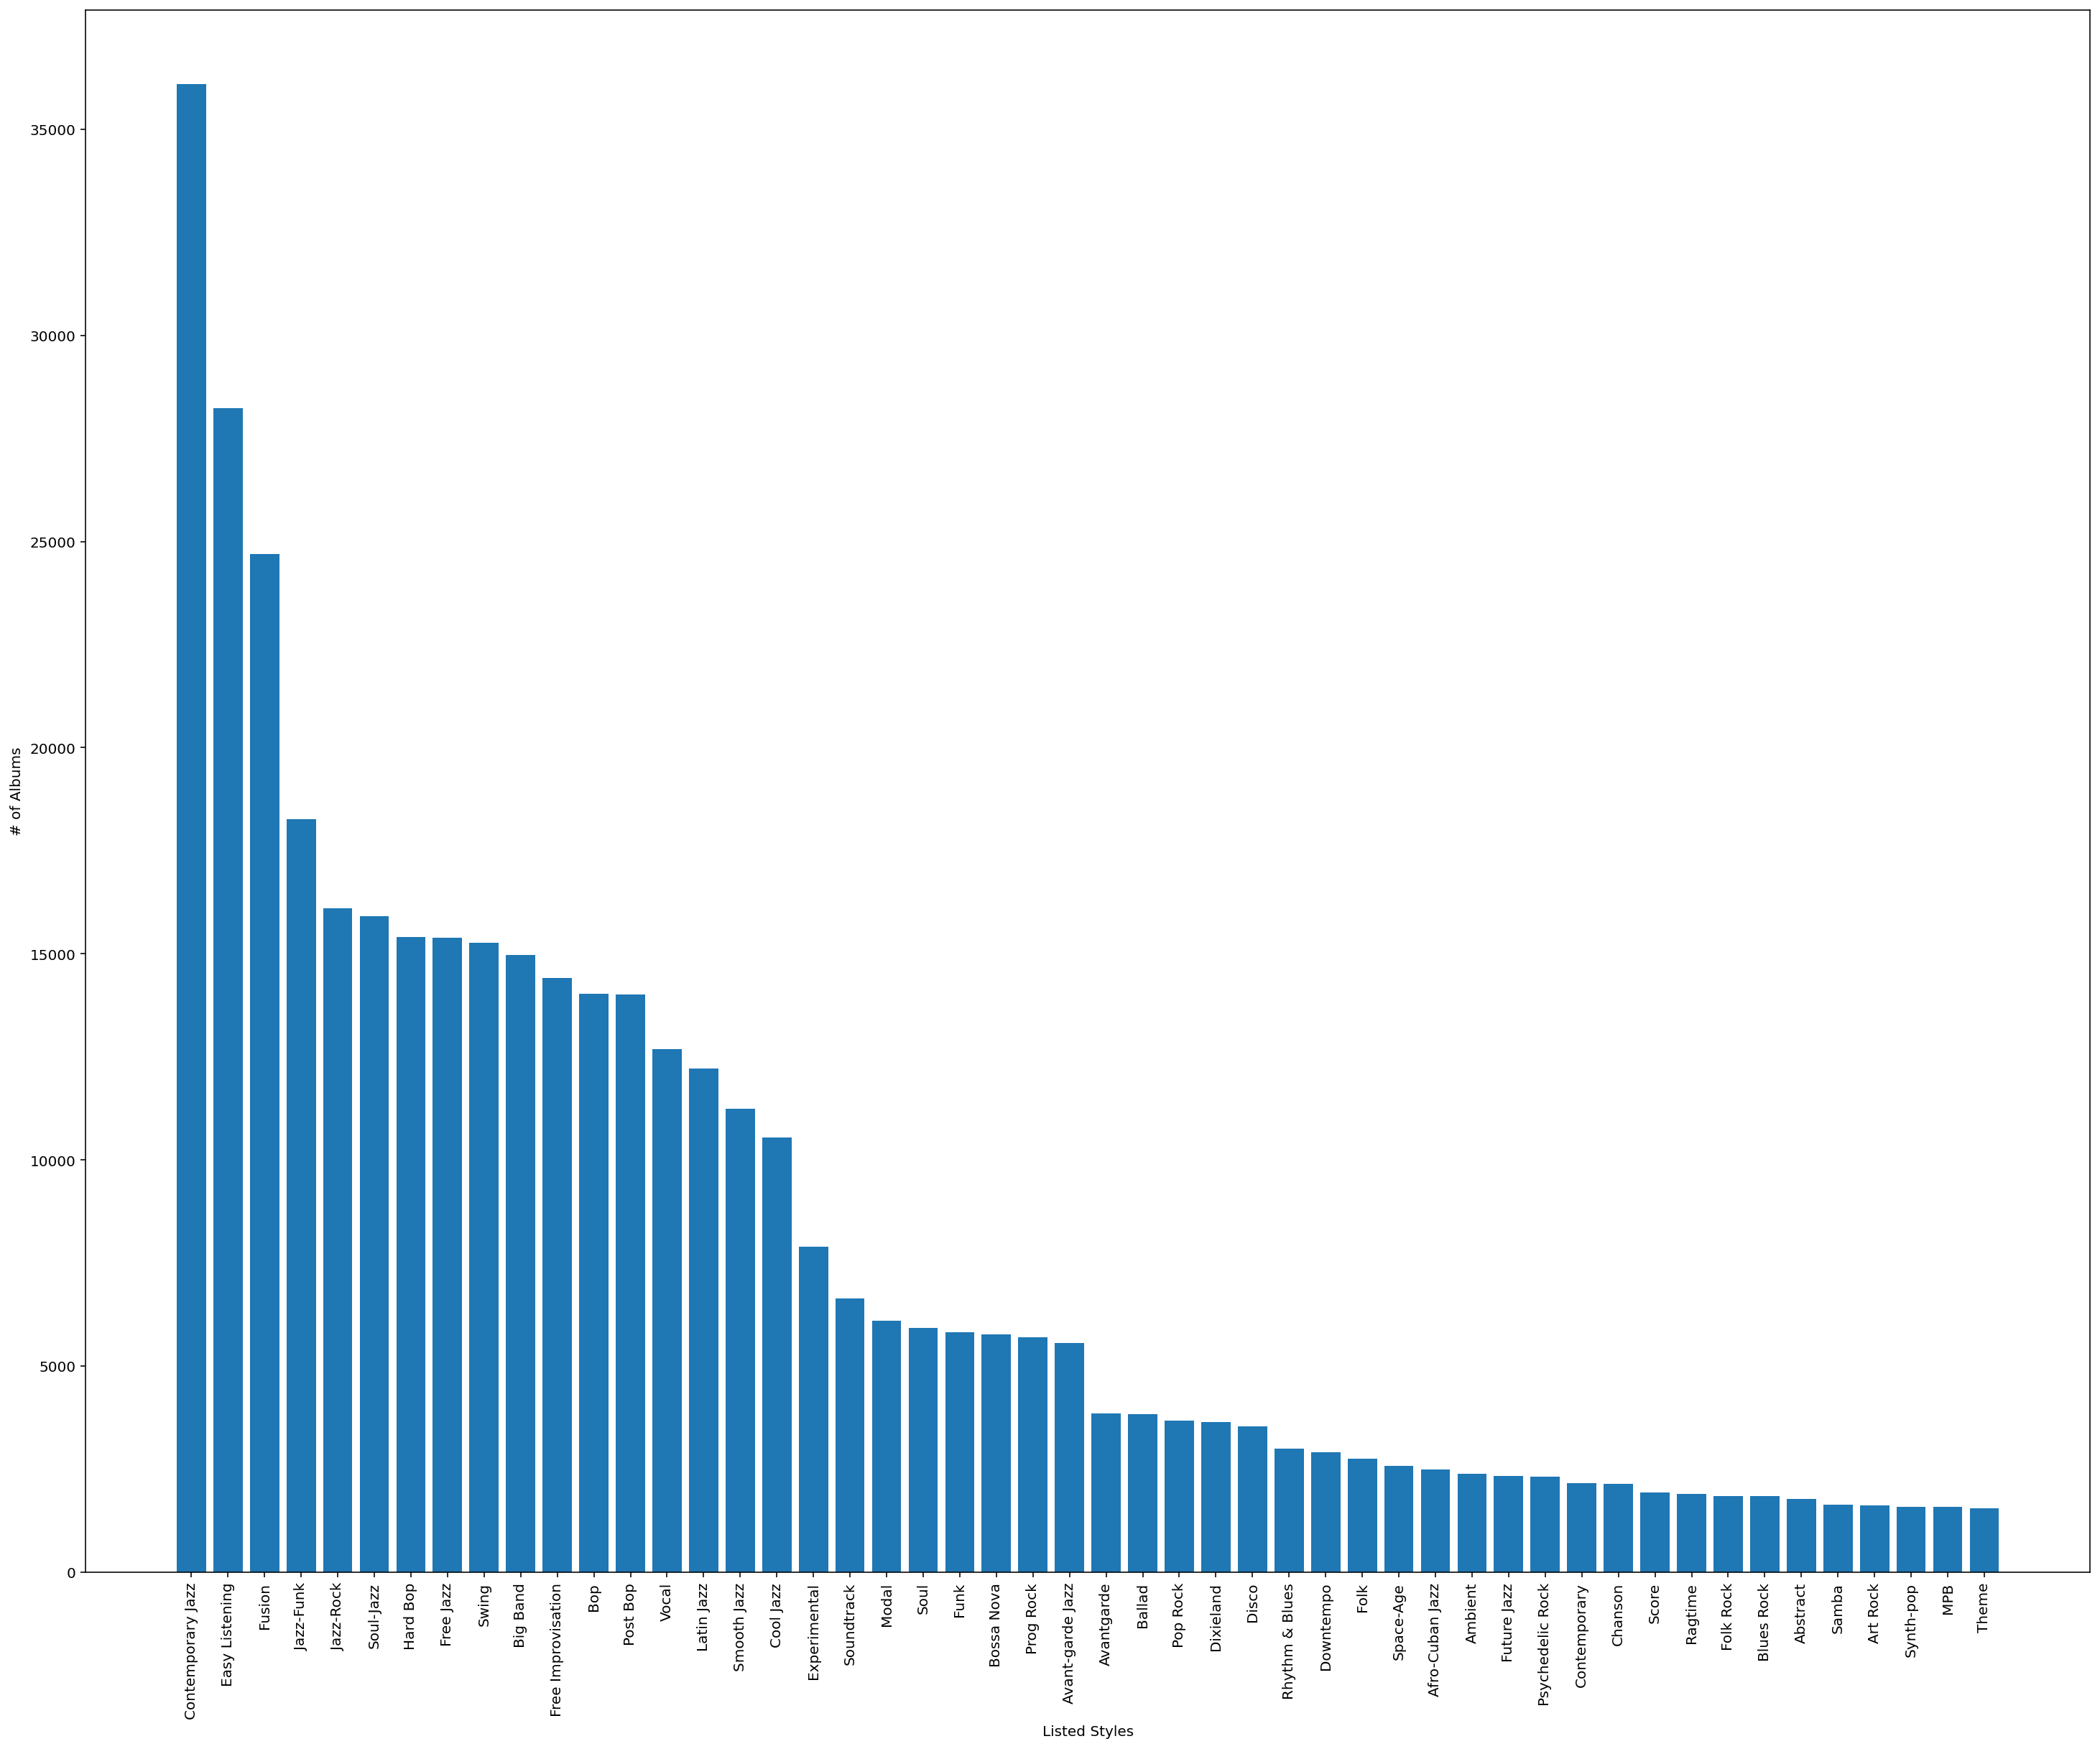

In [291]:
plt.figure(figsize=(25,20))
plt.xlabel('Listed Styles')
plt.ylabel('# of Albums')
plt.xticks(rotation=90)
plt.bar(style_sum_top_10.index,style_sum_top_10)
plt.show()

To reduce dimensionality, we'll only retain those features with over 250 (maybe 100) albums listed to them. We'll also construct a counter of how many styles the record has attributed to it

In [377]:
concat_df['style_count'] = concat_df[style_columns].sum(axis=1)

In [383]:
other_style_columns = list(filter(lambda x: concat_df[x].sum() < 250,style_columns)
concat_df[list(filter(lambda x: concat_df[x].sum() > 250,style_columns))]

,style_Contemporary,style_Leftfield,style_Hard Bop,style_Mambo,style_Salsa,style_Cubano,style_Country Blues,style_Modal,style_Theme,style_Deep House,...,style_Merengue,style_African,style_Rockabilly,style_Space-Age,style_Big Band,style_Dub,style_Noise,style_Experimental,style_Trip Hop,style_Afro-Cuban
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297541,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
297542,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
297543,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
297544,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Format Description

In [299]:
format_description_df, format_description_sum = get_encoded_df_and_count(format_description_columns)
format_description_sum.describe()

count        93.000000
mean       6874.064516
std       34431.596110
min           1.000000
25%           6.000000
50%          62.000000
75%         548.000000
max      296135.000000
dtype: float64

In [308]:
format_description_sum.iloc[:25]

Album                 296135
LP                    137985
Reissue                61535
Stereo                 35943
Remastered             24467
Mono                   23929
Limited Edition        16609
Promo                  11135
Compilation             6299
Club Edition            3239
Repress                 3095
10"                     2770
Numbered                1624
45 RPM                  1085
Test Pressing            882
Mini-Album               852
Enhanced                 851
12"                      774
Hybrid                   753
Quadraphonic             670
7"                       616
33 ⅓ RPM                 595
Special Edition          566
Unofficial Release       548
Deluxe Edition           528
dtype: int64

## Format Text

In [310]:
format_name_df, format_name_sum = get_encoded_df_and_count(format_name_columns)
format_name_sum.describe()

count        28.000000
mean      10626.071429
std       36727.782427
min           1.000000
25%           4.000000
50%          33.000000
75%         412.500000
max      141050.000000
dtype: float64

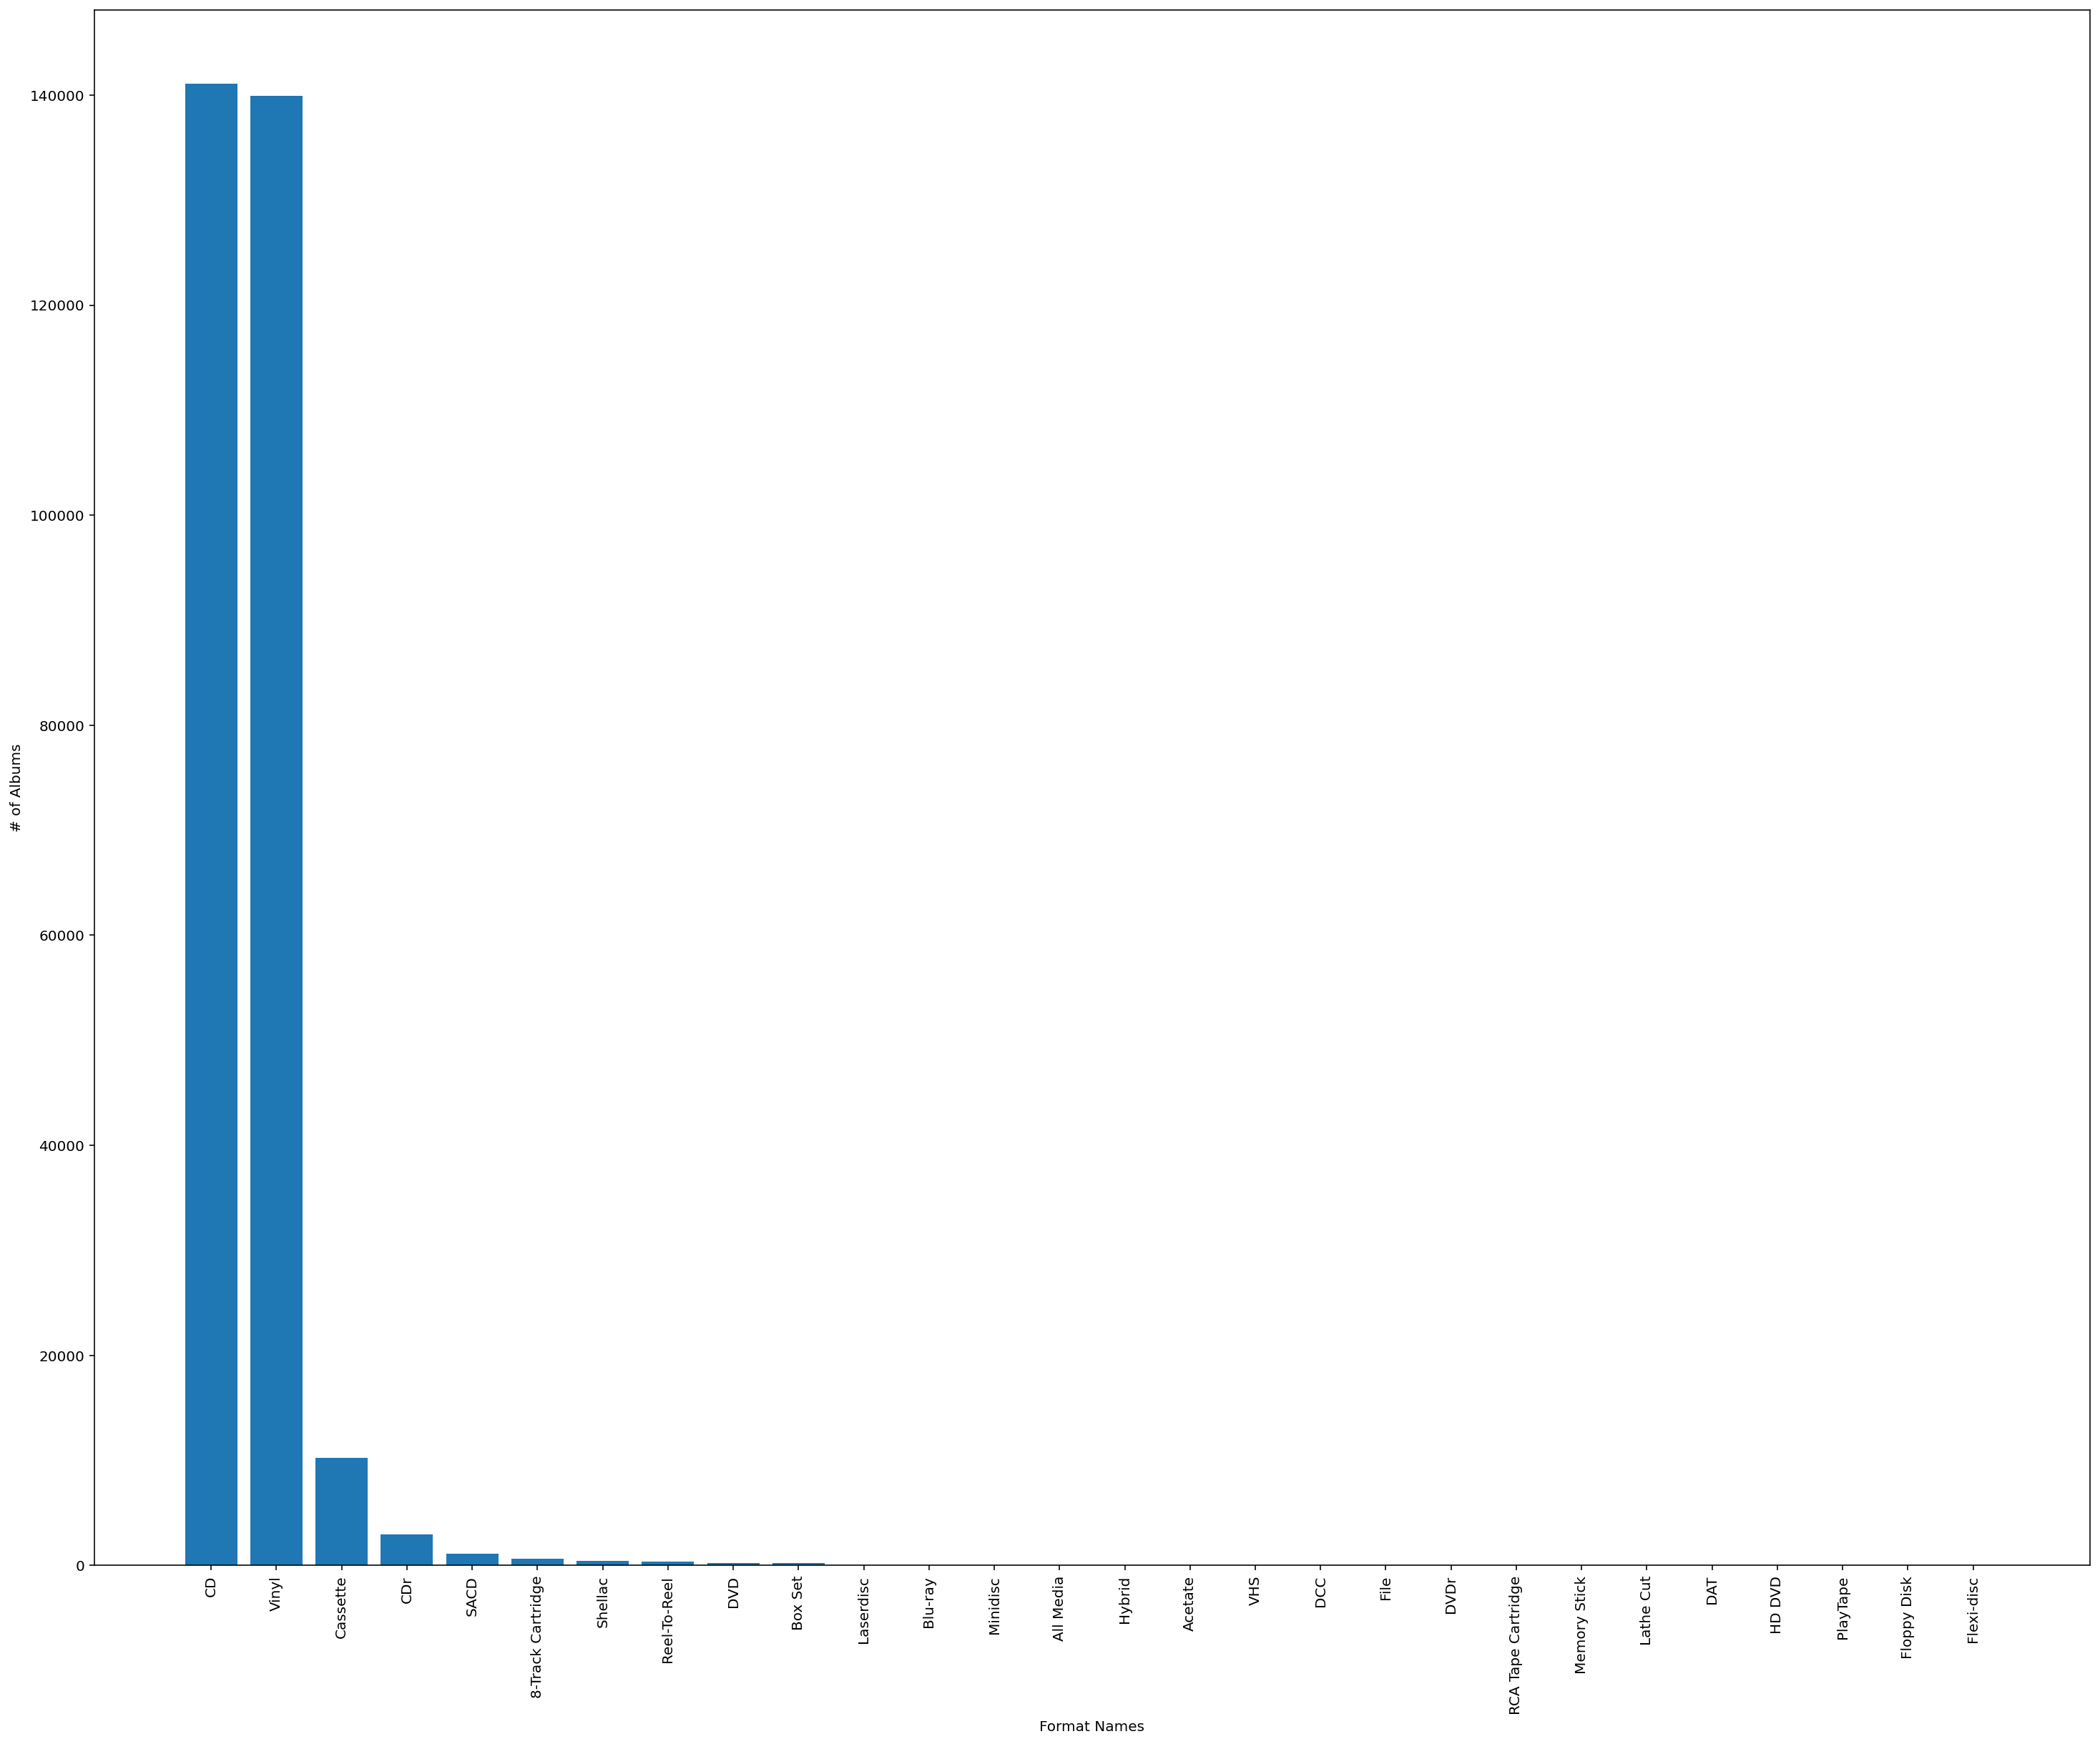

In [353]:
plt.figure(figsize=(25,20))
plt.xlabel('Format Names')
plt.ylabel('# of Albums')
plt.xticks(rotation=90)
plt.bar(format_name_sum.index,format_name_sum)
plt.show()

From the above, we can see that it would be wise to reduce the ``format_name`` indicator variable dimensionality, as there are really three non-trivially large format categories, namely ``CD``, ``Vinyl`` and ``Cassette``. The rest we will combine into an ``Other`` indicator. We will also combine ``CD`` and ``CDr``, as these formats are essentially equivalent

In [355]:
concat_df['format_name_CD'] = concat_df.loc[:,'format_name_CD'] + concat_df.loc[:,'format_name_CDr']
concat_df.drop('format_name_CDr',axis=1,inplace=True)

In [368]:
format_name_other_columns = list(filter(lambda x: x not in ['format_name_CD','format_name_Vinyl','format_name_Cassette','format_name_CDr'],format_name_columns))
concat_df['format_name_Other'] = concat_df.loc[:,format_name_other_columns].sum(axis=1)

In [370]:
concat_df.drop(format_name_other_columns,axis=1,inplace=True)

## Market Value
### Distribution

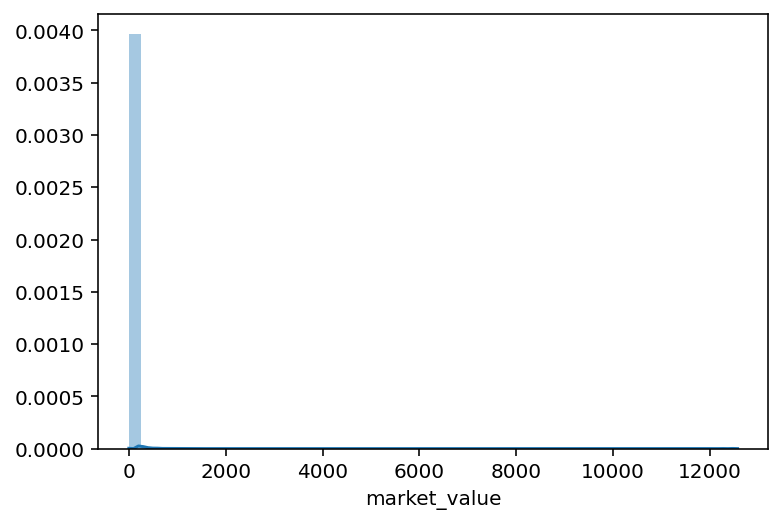

In [322]:
sns.distplot(concat_df['market_value'])

From the above we see that there is a huge left skew for market_value, which means we need to remove outliers

In [324]:
upper_bound = concat_df['market_value'].mean() + concat_df['market_value'].std()*3
lower_bound = concat_df['market_value'].mean() - concat_df['market_value'].std()*3

In [328]:
def remove_market_value_outliers(df):
    df = df.copy()
    
    df = df[df['market_value'] < df['market_value'].mean() + df['market_value'].std()*3]
    
    return df

In [329]:
concat_df = remove_market_value_outliers(concat_df)

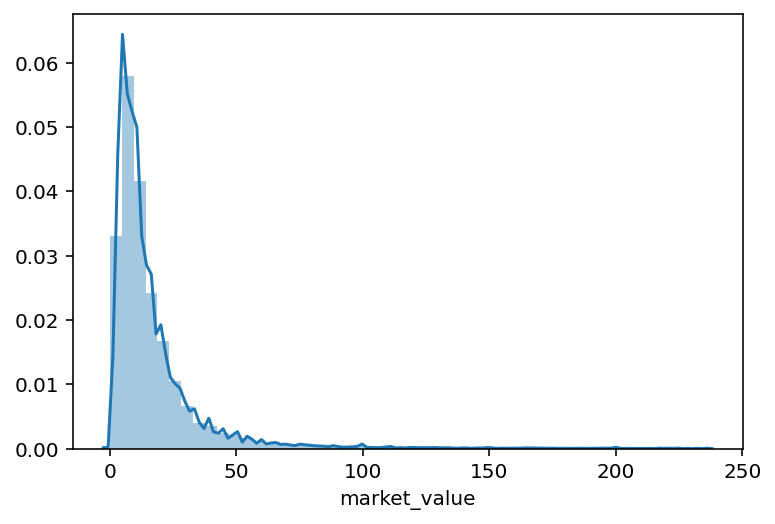

In [331]:
sns.distplot(concat_df['market_value'])

After removing entries with ``market_value`` values exceeding 3 standard deviations from the mean, we see that the distribution has skewed less, making it a prime candidate for log treatment

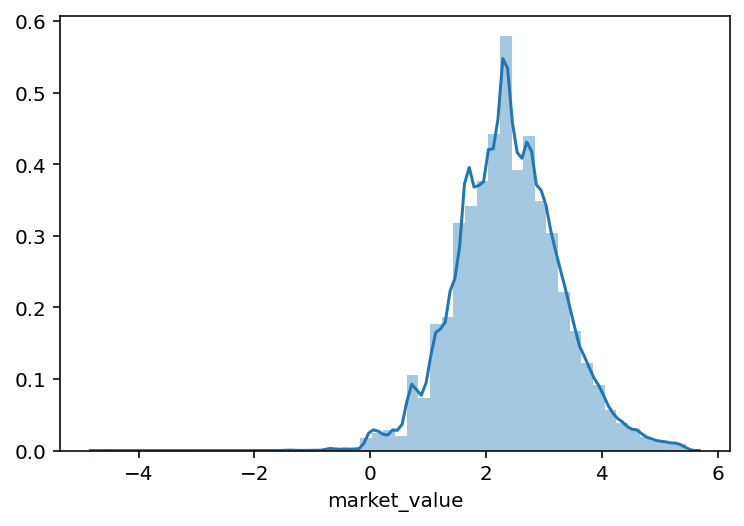

In [332]:
sns.distplot(np.log(concat_df['market_value']))

## Evolution of Market Value over Time

In [ ]:
def fill_below_for(Y,begin,end):
    """
    fill the region below the intersection of S and Z
    """
    # compute a new curve which we will fill below
    Y = nx.zeros(S.shape, typecode=nx.Float)
    
    p.fill(x, Y, facecolor='blue', alpha=0.5)

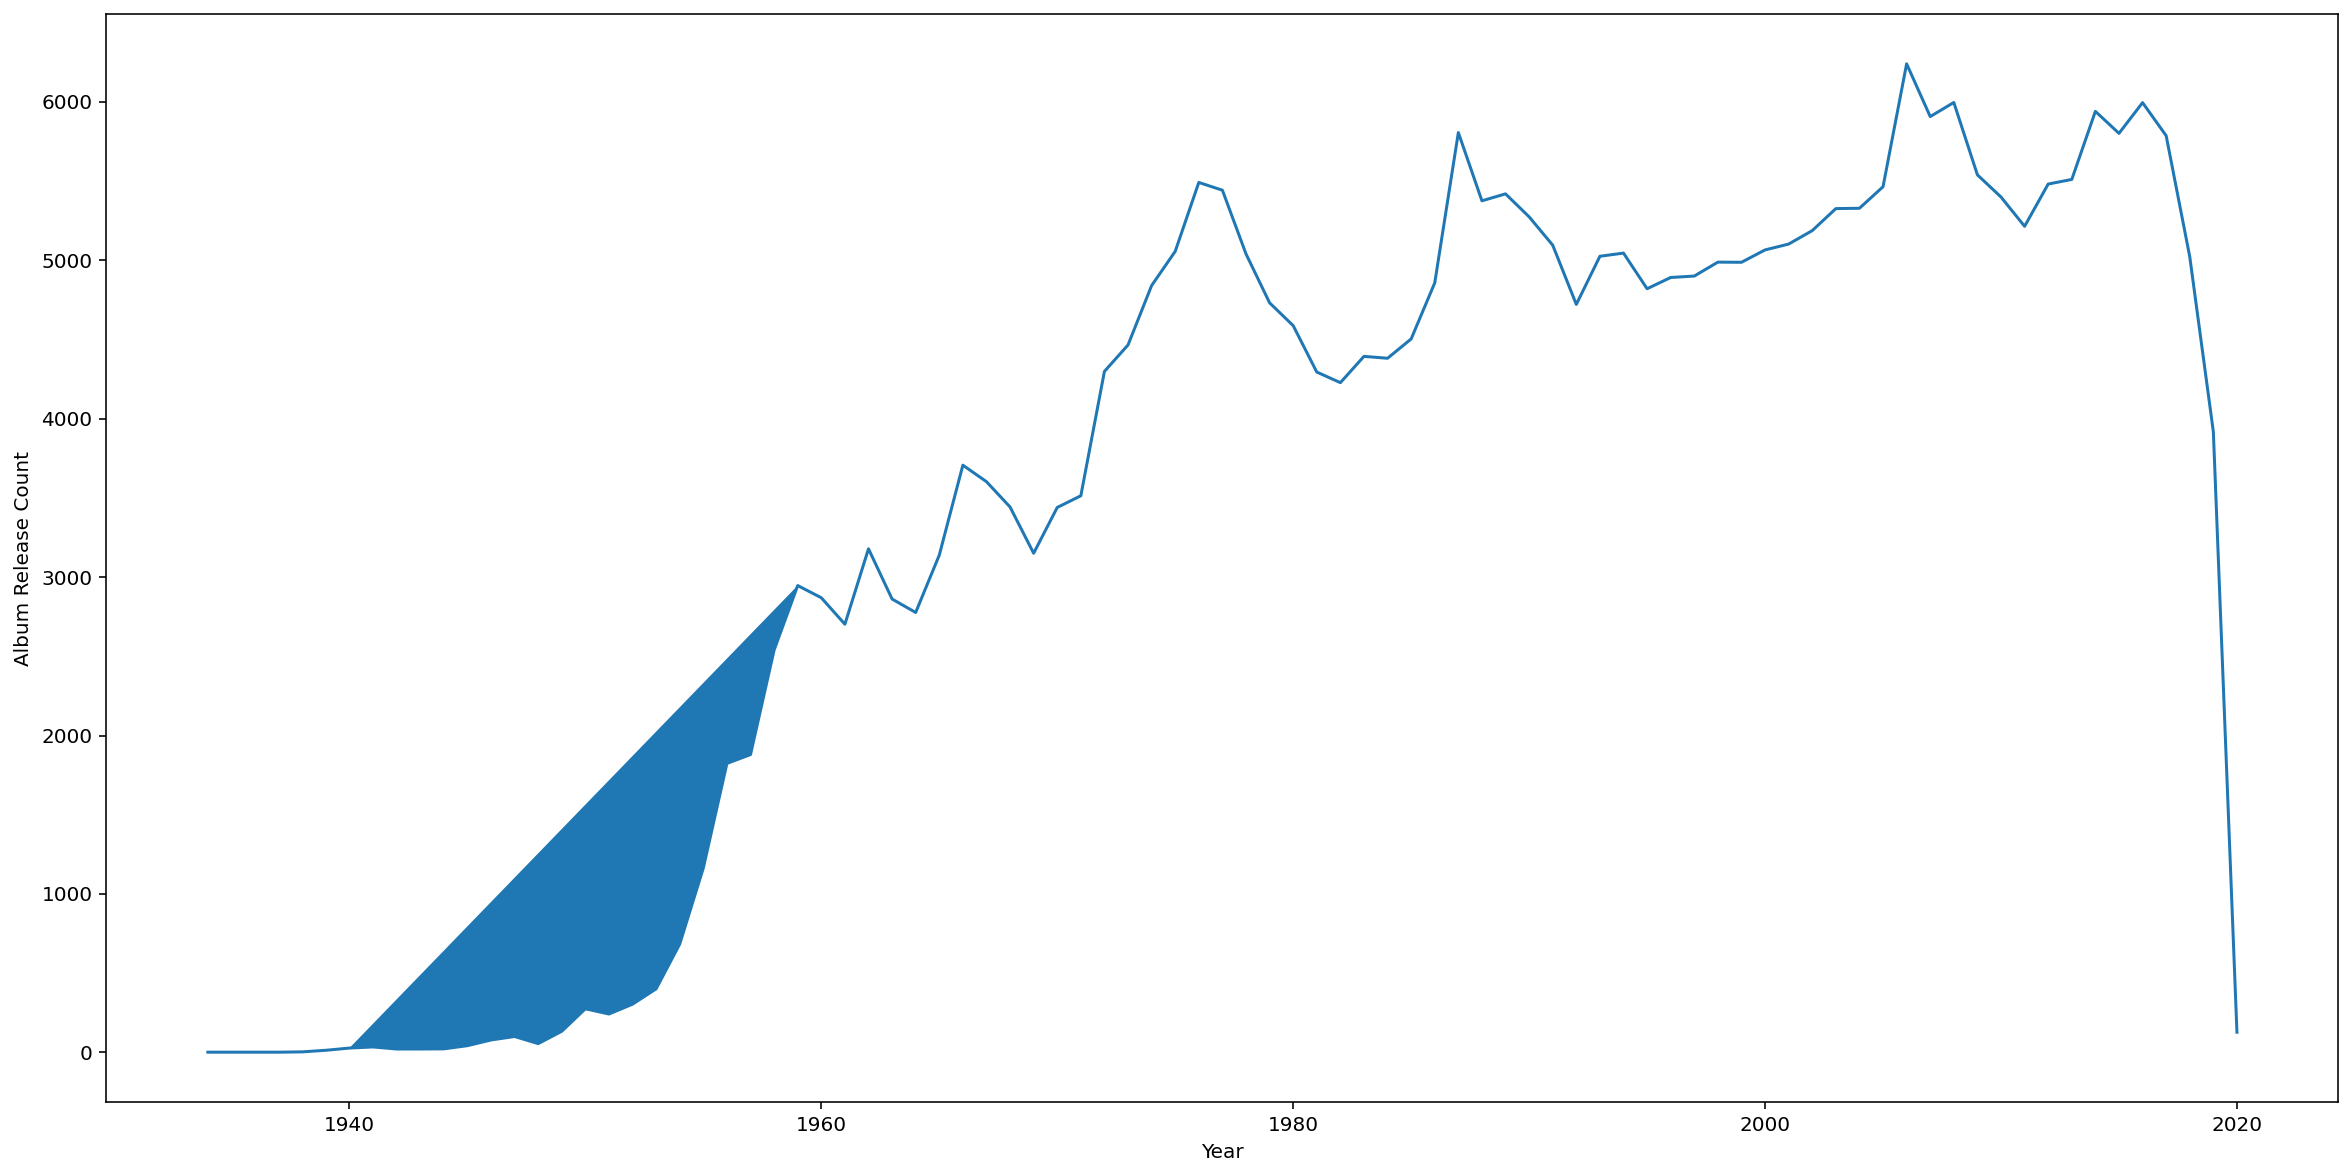

In [316]:
plt.figure(figsize=(20,10))
plt.xlabel('Year')
plt.ylabel('Album Release Count')
plt.plot(concat_df.groupby(by='year')['market_value'].count())
plt.fill([i for i in range(1940,1960)],concat_df.groupby(by='year')['market_value'].count().loc[1940:1959])
plt.show()

In [224]:
max(concat_df.groupby(by='year')['market_value'].std().dropna())

426.559442685873

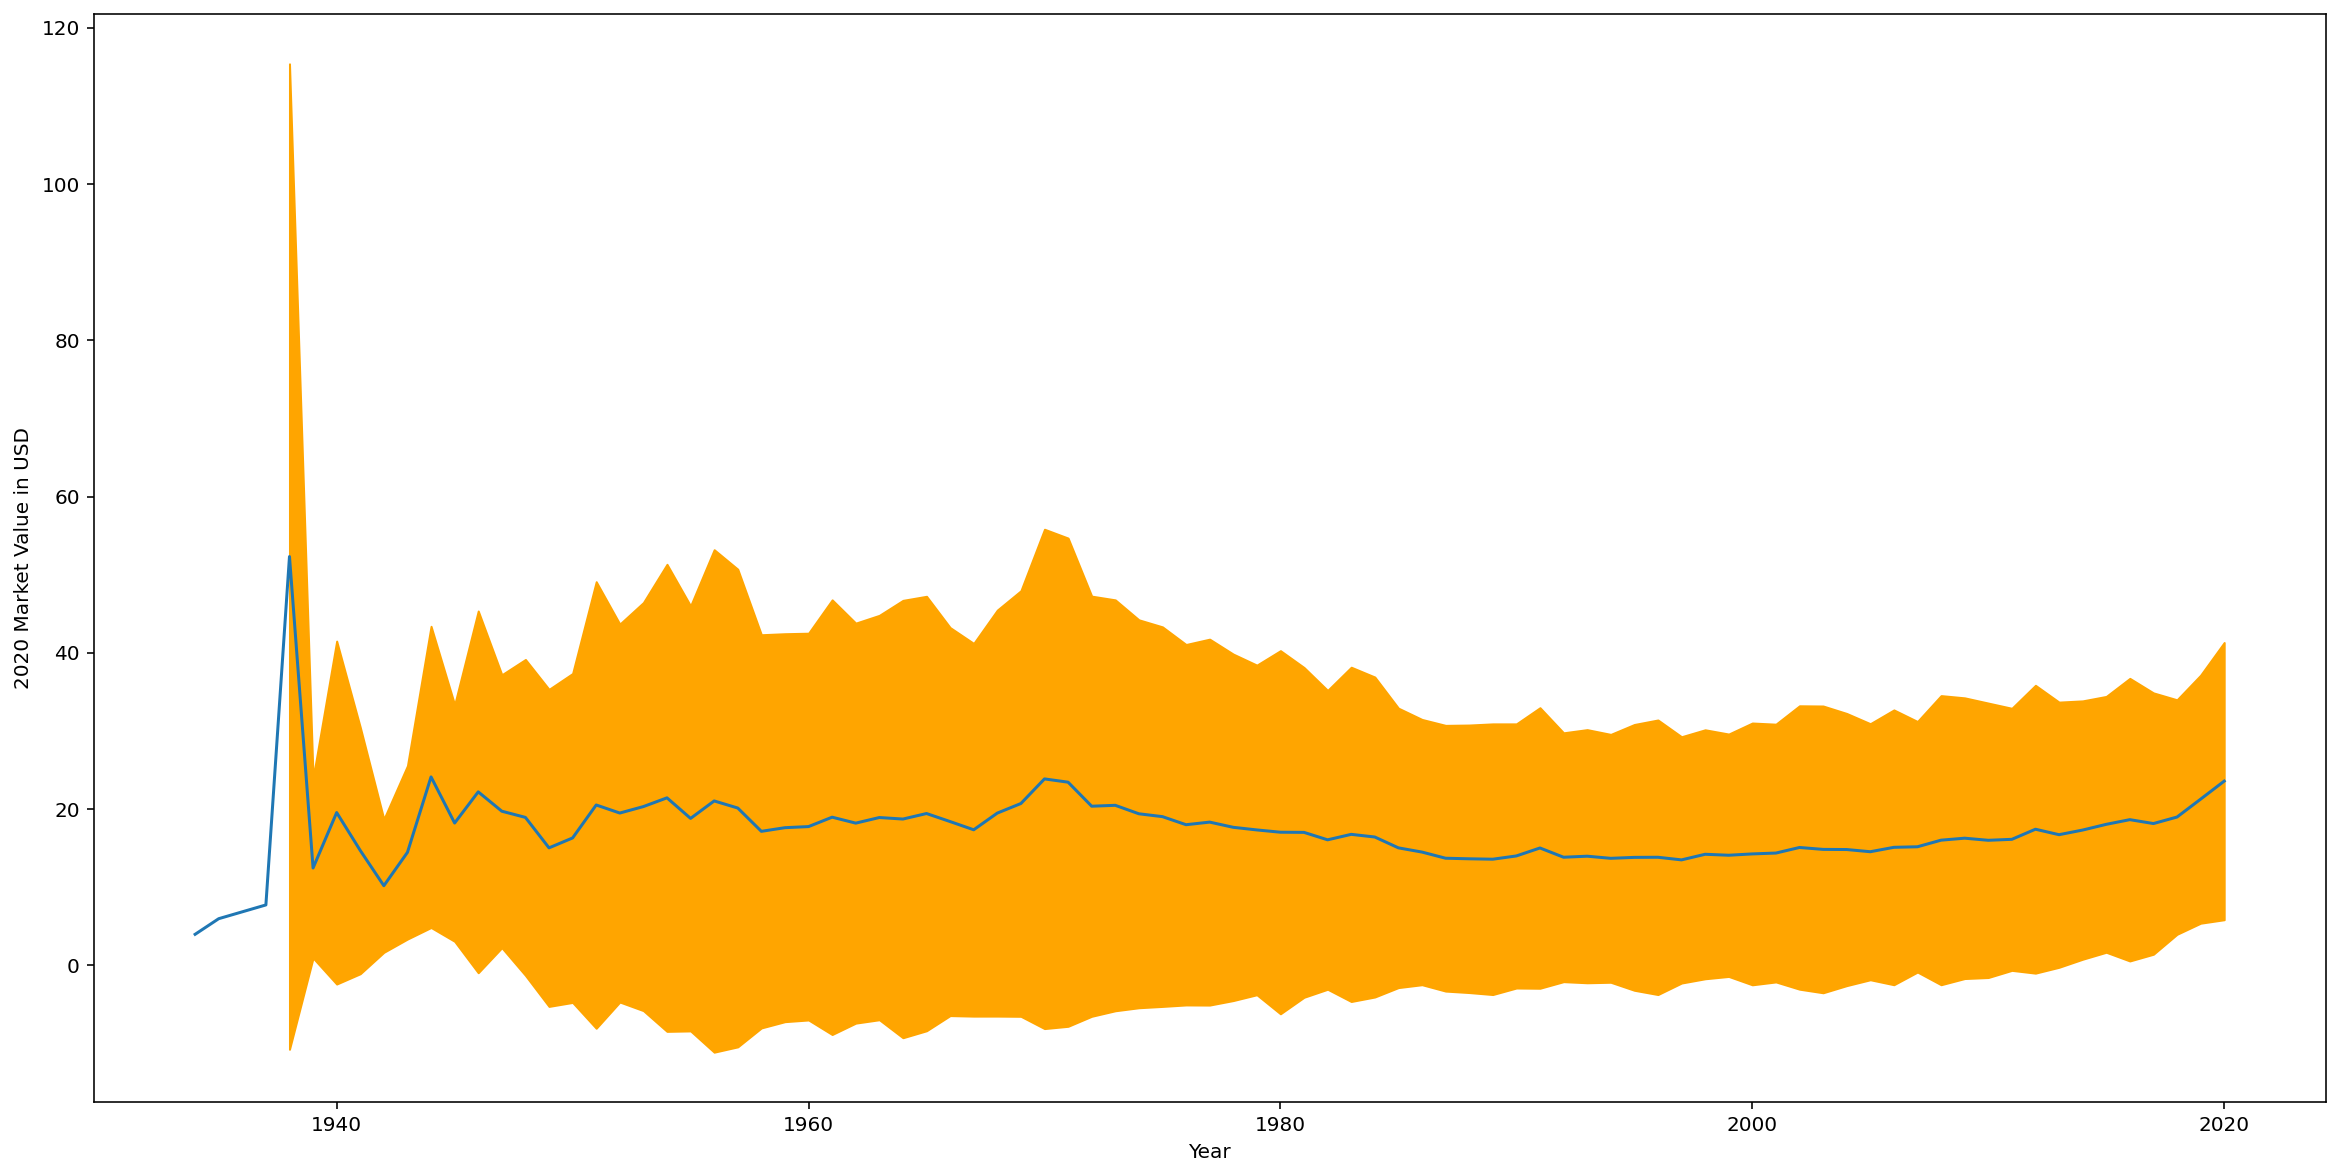

In [339]:
plt.figure(figsize=(20,10))
plt.xlabel('Year')
plt.ylabel('2020 Market Value in USD')
plt.plot(concat_df.groupby(by='year')['market_value'].mean())
mean_value = concat_df.groupby(by='year')['market_value'].mean()
std_error = concat_df.groupby(by='year')['market_value'].std()
plt.fill_between(std_error.index, mean_value-std_error, mean_value+std_error,color='orange')
plt.show()

## Mapping Most Albums

In [119]:
map_df = gpd.read_file(os.path.join(DATA_PATH,'countries/ne_110m_admin_0_countries.shp'))

In [147]:
visualization_countries = list(filter(lambda x: x not in ['country_yugoslavia','country_ussr','country_taiwan'],country_columns))
country_album_count = concat_df[visualization_countries].sum()

In [145]:
country_codes = pd.Series([COUNTRY_CODES[country.split('_')[-1]] for country in visualization_countries],index=visualization_countries)

In [154]:
country_df = pd.DataFrame(country_album_count)

In [155]:
country_df['codes'] = country_codes

In [161]:
country_df['ISO_A3'] = country_df.loc[:,'codes'].map(M49_TO_ISO3) 

In [187]:
country_df.sort_values(0)

,0,codes,ISO_A3
country_tunisia,1,788,TUN
country_french polynesia,1,258,PYF
country_cabo verde,1,132,CPV
country_albania,1,008,ALB
country_saint lucia,1,662,NaN
...,...,...,...
country_france,14711,250,FRA
country_germany,23490,276,DEU
country_united kingdom of great britain and northern ireland,23553,826,GBR
country_japan,40166,392,JPN


In [164]:
merge = map_df.set_index('ISO_A3').join(country_df.set_index('ISO_A3'))

In [177]:
merge.fillna(0,inplace=True)

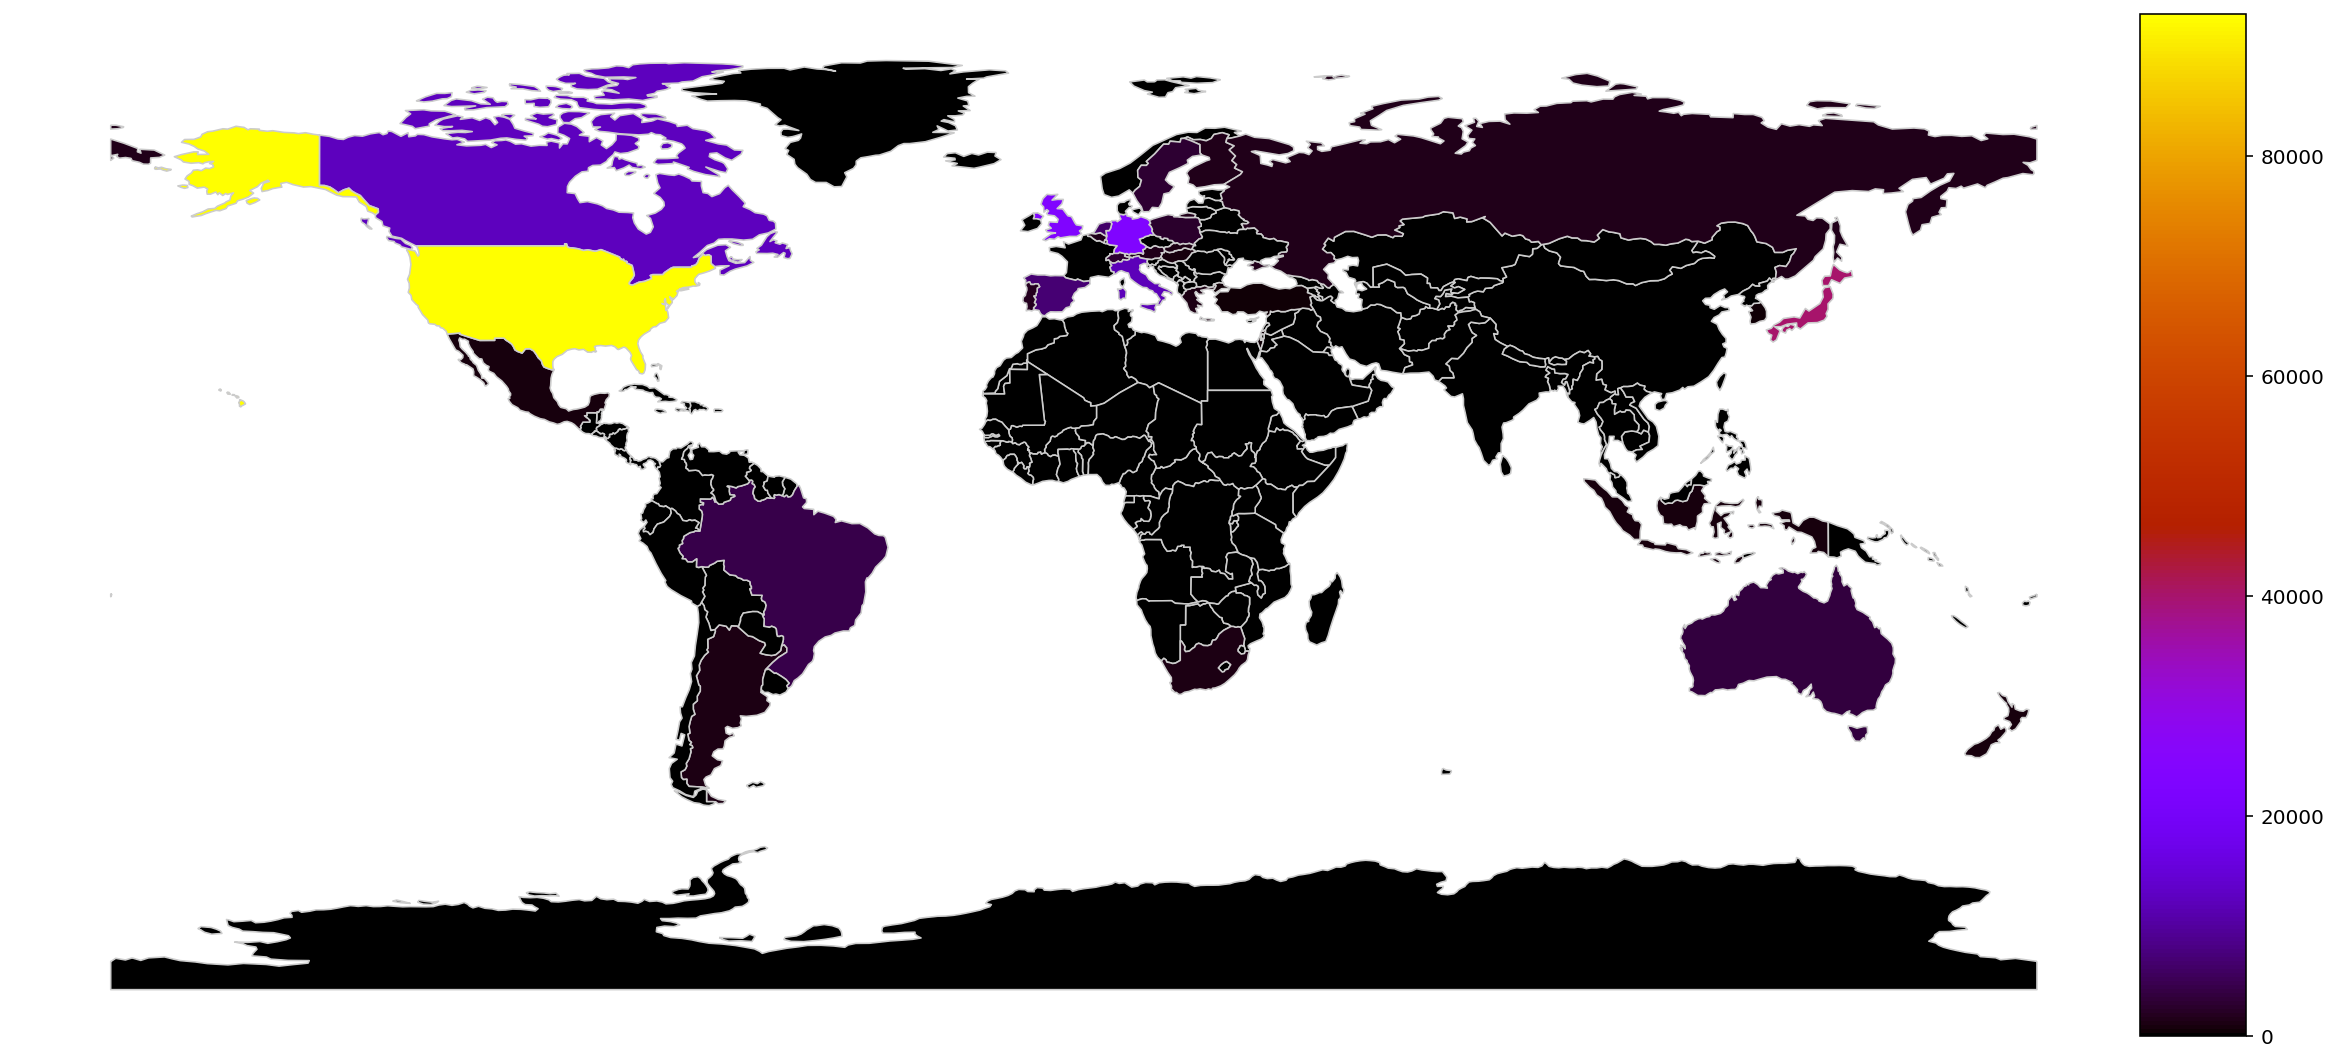

In [208]:
vmin, vmax = min(merge[0]),max(merge[0])
fig, ax = plt.subplots(1,figsize=(20,20))
merge.plot(column=0,cmap='gnuplot',linewidth=0.8,ax=ax,edgecolor='0.8')
ax.axis('off')
sm = plt.cm.ScalarMappable(cmap='gnuplot',norm=plt.Normalize(vmin=vmin,vmax=vmax))
sm._a = []
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(sm,cax=cax)
plt.show()

# High Level Features
## Loading and Cleaning

In [31]:
data_loader = DataLoader()
high_level_features = data_loader.load_high_level_features()
high_level_feature_df = pd.DataFrame()
for feature_chunk in tqdm(high_level_features):
    high_level_feature_df = pd.concat([high_level_feature_df,feature_chunk],axis=0)

36it [08:30, 14.17s/it]


KeyError: "['index'] not found in axis"

In [35]:
high_level_feature_df = high_level_feature_df.reset_index(drop=True).drop('index',axis=1).astype({'release_id':np.uint32,'bitmap':np.uint8})

In [36]:
high_level_feature_df

,release_id,bitmap,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_1271,feature_1272,feature_1273,feature_1274,feature_1275,feature_1276,feature_1277,feature_1278,feature_1279,feature_1280
0,10000059,0,1.515982,0.985522,1.007454,0.000000,0.000000,0.038283,0.128865,1.145386,...,0.114205,0.541623,0.000000,0.749873,0.098970,0.000000,0.000000,0.005582,0.000000,0.271306
1,10000099,0,0.107666,0.012730,0.708745,0.038983,0.014043,0.034137,0.063565,0.571926,...,0.000000,0.330848,0.326690,0.526954,2.056569,0.004467,0.001381,0.000000,0.760751,0.000000
2,10000106,0,0.772954,1.777797,0.335263,0.000000,0.982789,0.181303,0.000000,0.456971,...,0.000000,0.012951,0.525019,0.000000,4.226579,0.000000,0.617199,0.000000,0.615453,0.000000
3,10000120,0,0.031700,0.000000,0.407634,0.000000,0.000000,0.000000,0.680883,0.136133,...,0.000000,0.025783,0.000000,0.072506,1.413647,0.037377,0.560480,0.000000,0.049533,0.304863
4,10000148,0,0.000000,2.523202,0.000000,0.143037,0.000000,0.000000,0.127924,0.416034,...,0.000000,0.361263,0.000000,0.333124,0.000000,0.000000,0.389682,0.028799,0.042345,0.944980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350325,9997153,1,0.699354,2.161860,0.111729,0.387642,0.000000,0.000000,0.000000,0.098190,...,3.471008,0.018930,0.000000,0.000000,0.000000,0.007879,0.000000,0.000000,0.382585,0.539629
350326,9997315,1,0.699354,2.161860,0.111729,0.387642,0.000000,0.000000,0.000000,0.098190,...,3.471008,0.018930,0.000000,0.000000,0.000000,0.007879,0.000000,0.000000,0.382585,0.539629
350327,9997396,1,0.699354,2.161860,0.111729,0.387642,0.000000,0.000000,0.000000,0.098190,...,3.471008,0.018930,0.000000,0.000000,0.000000,0.007879,0.000000,0.000000,0.382585,0.539629
350328,9997519,1,0.699354,2.161860,0.111729,0.387642,0.000000,0.000000,0.000000,0.098190,...,3.471008,0.018930,0.000000,0.000000,0.000000,0.007879,0.000000,0.000000,0.382585,0.539629


In [348]:
high_level_feature_df = high_level_feature_df.merge(concat_df,on='release_id',how='right')

In [60]:
import umap

In [75]:
data = high_level_feature_df.drop(['release_id','bitmap'],axis=1).dropna(how='all')

In [65]:
reducer = umap.UMAP()

In [76]:
embedding = reducer.fit_transform(data)

/Users/simonhelmig/anaconda3/envs/exts-ml/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../anaconda3/envs/exts-ml/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/Users/simonhelmig/anaconda3/envs/exts-ml/lib/python3.6/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..

In [77]:
embedding.shape

(297356, 2)

ValueError: 'c' argument has 296158 elements, which is inconsistent with 'x' and 'y' with size 297356.

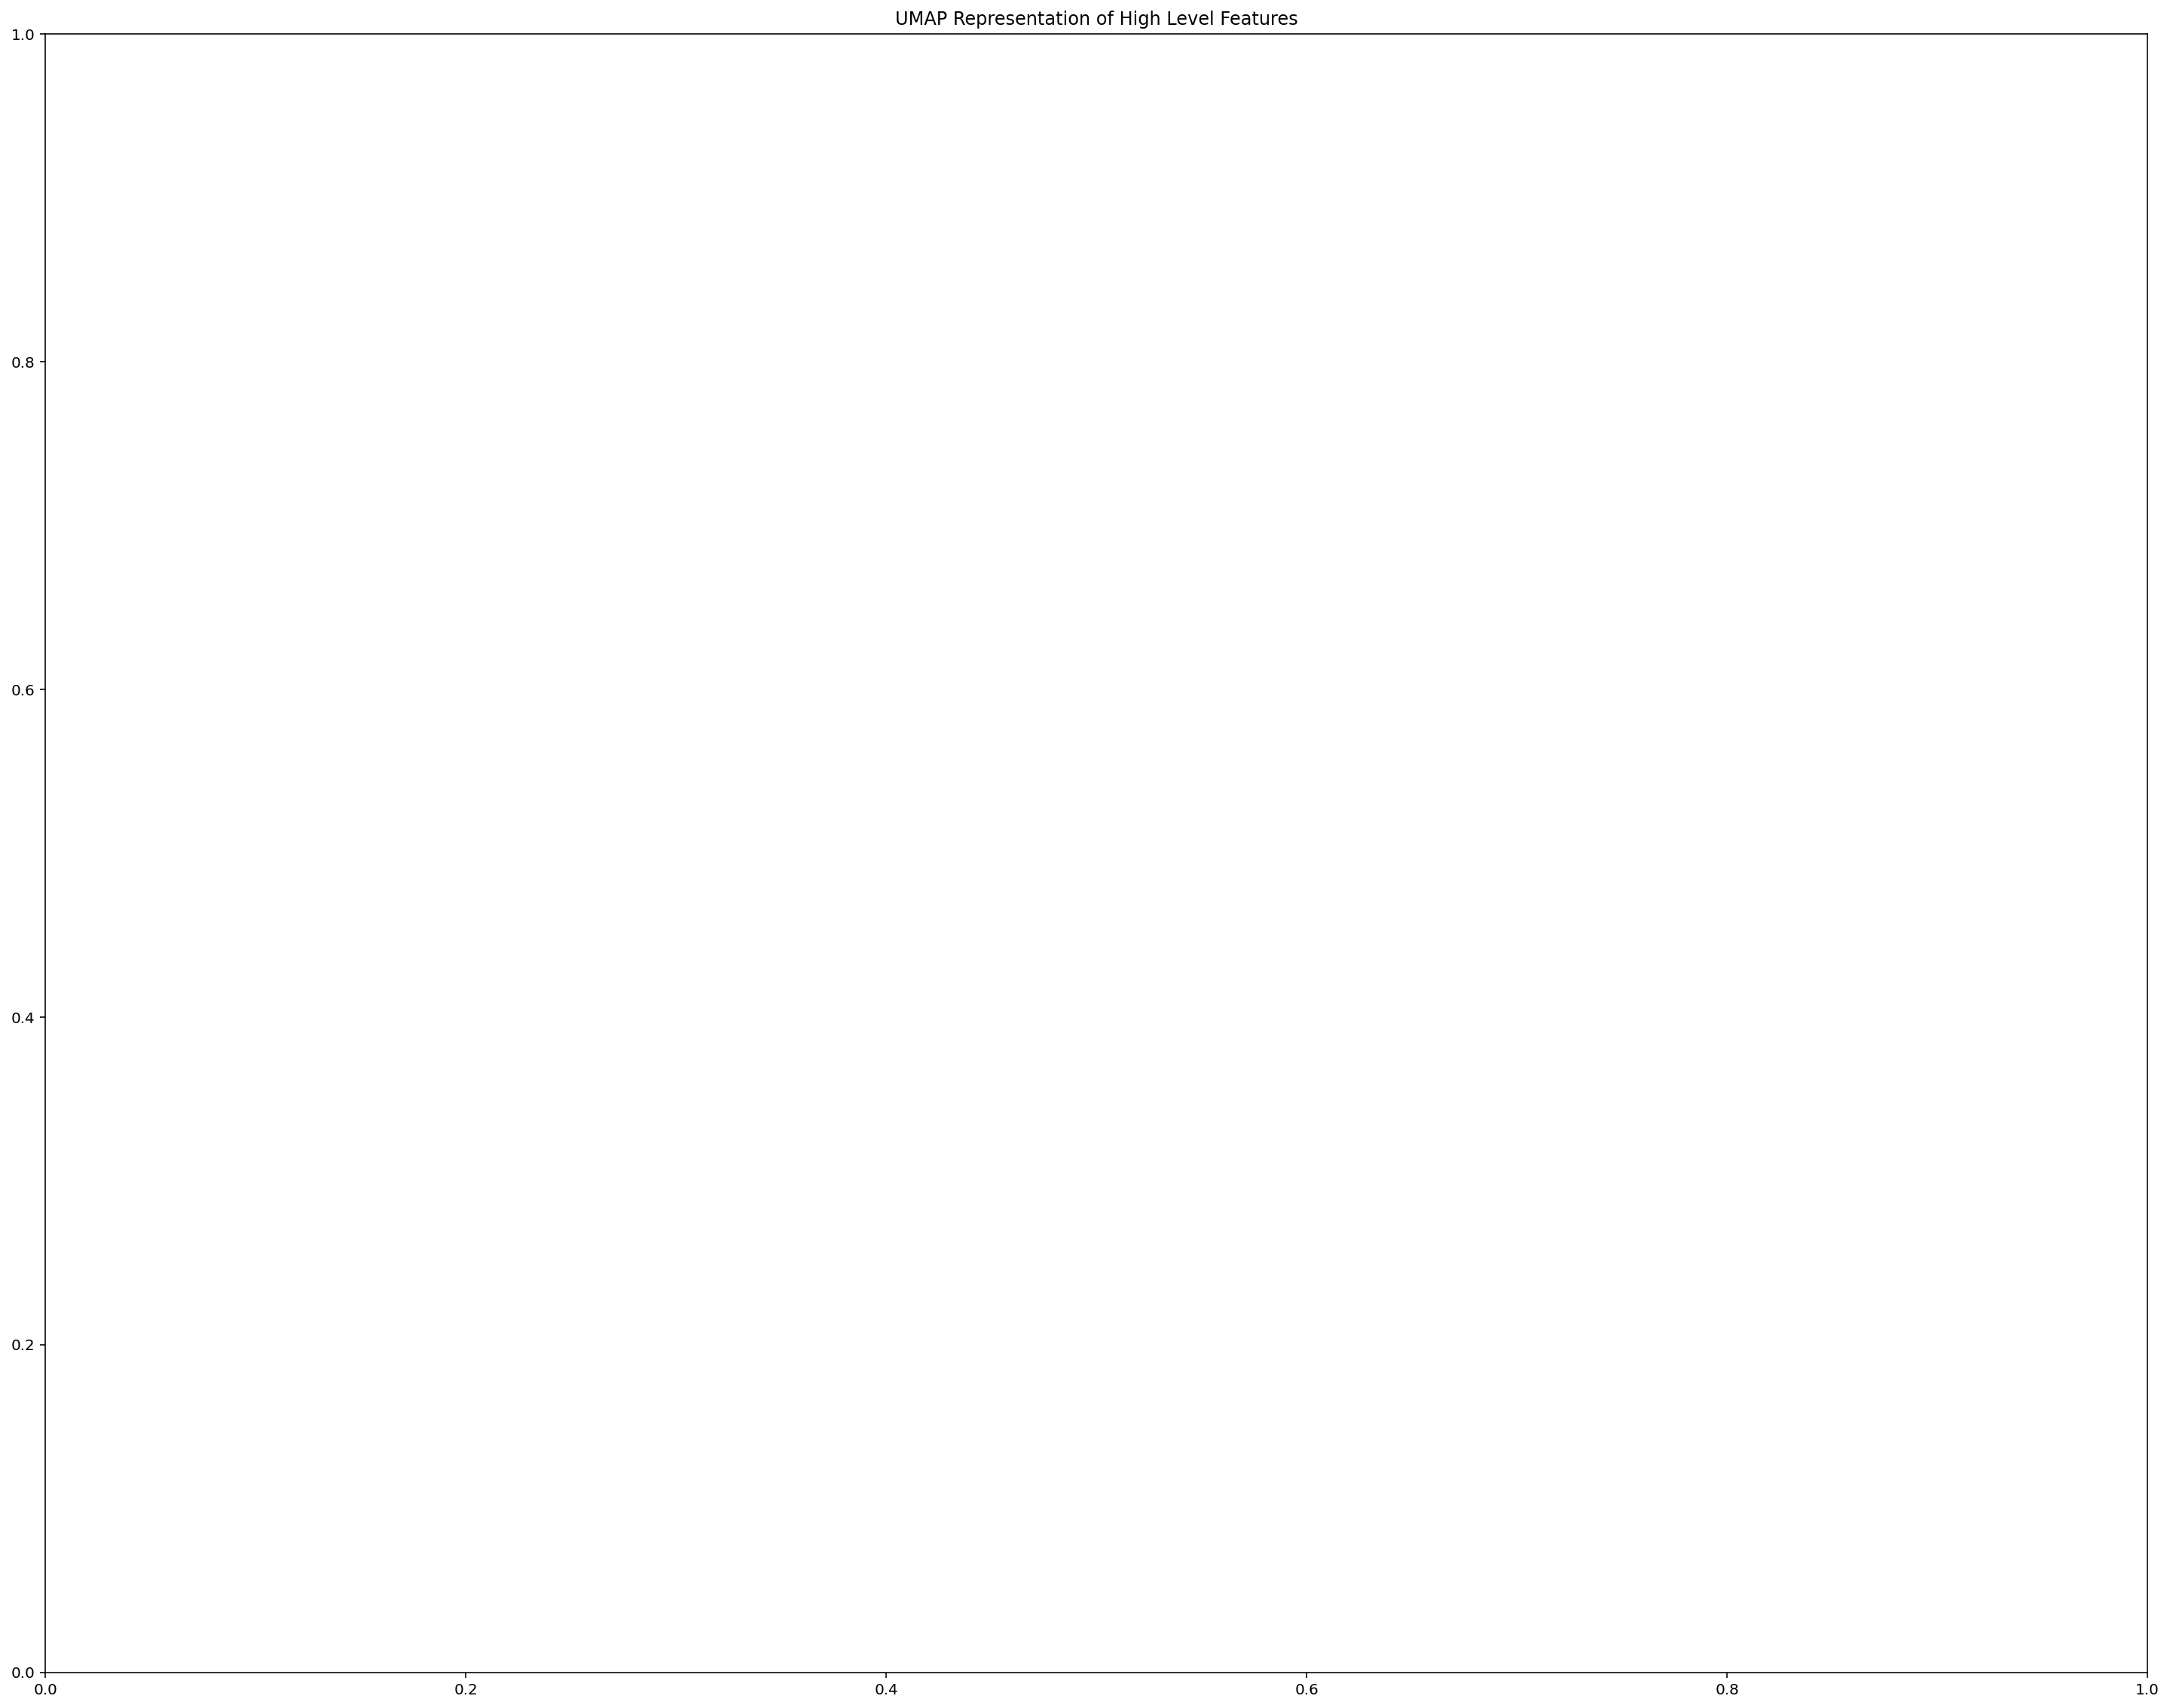

In [347]:
plt.figure(figsize=(25,20))
plt.title('UMAP Representation of High Level Features')
plt.scatter(embedding[:,0],embedding[:,1],c=concat_df['genre_Electronic'])
plt.show();

In [341]:
help(plt.scatter)

Help on function scatter in module matplotlib.pyplot:

scatter(x, y, s=None, c=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=<deprecated parameter>, edgecolors=None, *, plotnonfinite=False, data=None, **kwargs)
    A scatter plot of *y* vs. *x* with varying marker size and/or color.
    
    Parameters
    ----------
    x, y : scalar or array-like, shape (n, )
        The data positions.
    
    s : scalar or array-like, shape (n, ), optional
        The marker size in points**2.
        Default is ``rcParams['lines.markersize'] ** 2``.
    
    c : color, sequence, or sequence of colors, optional
        The marker color. Possible values:
    
        - A single color format string.
        - A sequence of colors of length n.
        - A scalar or sequence of n numbers to be mapped to colors using
          *cmap* and *norm*.
        - A 2-D array in which the rows are RGB or RGBA.
    
        Note that *c* should not be a single 